## Use the ProcessWordle Module

In [ ]:
import ProcessWordle as ScrabblePoints, ParseWordle
import censoring

In [ ]:
sp = ScrabblePoints(censoring.wordle_answers_input)
sp.read_wordle_answers()
sp.add_total_and_difficulty()

pw = ParseWordle(
    censoring.raw_whatsapp_input, 
    censoring.wordle_output,
    censoring.name_alias
)
pw.create_wordle_df()
pw.process_data_frame()
pw.join_data_frame(sp.words_df)
pw.write_final_df()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import censoring
from scipy.special import logit, expit

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [2]:
# load data
df = pd.read_csv(censoring.wordle_output)

In [3]:
# limit to the puzzle in which we last have words (396)
df2 = df[ (df['PuzzleNum'] < 447) & (df['PuzzleNum'] != 421) & (df['Difficulty'] != 'Undefined')].copy()

In [4]:
df2.head()

,Date_Time,Name,Game,PuzzleNum,FinalScore,Fails,Answer,ScrabblePoints,Difficulty
0,2021-12-31 10:46:00,Player1,Wordle,195,6,5,unify,11.0,Medium
1,2021-12-31 10:47:00,Player2,Wordle,195,6,5,unify,11.0,Medium
2,2021-12-31 11:02:00,Player3,Wordle,195,3,2,unify,11.0,Medium
3,2021-12-31 13:46:00,Player4,Wordle,195,5,4,unify,11.0,Medium
4,2022-01-01 11:58:00,Player3,Wordle,196,5,4,rebus,7.0,Easy


In [5]:
name_factor, player_names = pd.factorize(df2['Name'], sort=True)
diff_factor, diff_categ = pd.factorize(df2['Difficulty'], sort=True)

In [6]:
coords = {
    "obs": df2.index.values,  
    "player_names": player_names,
    "diff_categ": diff_categ
}

## Model 0

In [14]:
with pm.Model(coords=coords) as BB0:
    
    # Names
    NamesΘα = pm.Gamma("NamesΘα", alpha=3, beta=3, dims="player_names")
    NamesΘβ = pm.Gamma("NamesΘβ", alpha=3, beta=3, dims="player_names")
    
    # Difficulty
    DiffΘα = pm.Gamma("DiffΘα", alpha=3, beta=3, dims="diff_categ")
    DiffΘβ = pm.Gamma("DiffΘβ", alpha=3, beta=3, dims="diff_categ")
    
    # Names/Difficulty interaction
    interθα = pm.Gamma("interθα", alpha=3, beta=3, dims=("player_names", "diff_categ"))
    interθβ = pm.Gamma("interθβ", alpha=3, beta=3, dims=("player_names", "diff_categ"))
    
    # likelihood
    Fails = pm.BetaBinomial(
        "Fails", 
        n=6, 
        alpha=NamesΘα[name_factor] + DiffΘα[diff_factor] + interθα[name_factor, diff_factor], 
        beta=NamesΘβ[name_factor] + DiffΘβ[diff_factor] + interθβ[name_factor, diff_factor], 
        observed=df2["Fails"].values
    )

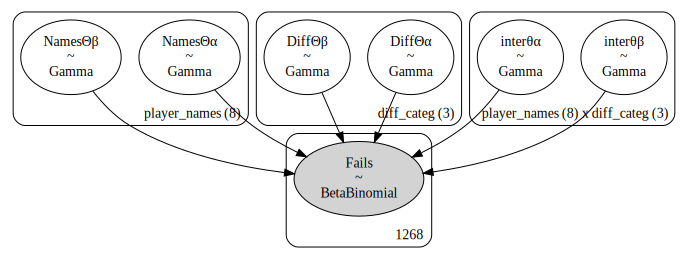

In [15]:
pm.model_to_graphviz(BB0)

In [16]:
with BB0:
    trace0 = pm.sample(
        1000,
        tune=2000,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [NamesΘα, NamesΘβ, DiffΘα, DiffΘβ, interθα, interθβ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 217 seconds.


## Display Widely-Acceptable Information Criterion

'p_waic' refers to the effective number of parameters; elpd_waic refers to the 'expected log pointwise predictive density'.

In [17]:
az.waic(trace0)

Computed from 4000 posterior samples and 1268 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1974.20    12.26
p_waic        7.36        -

# Plot Coefficients

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

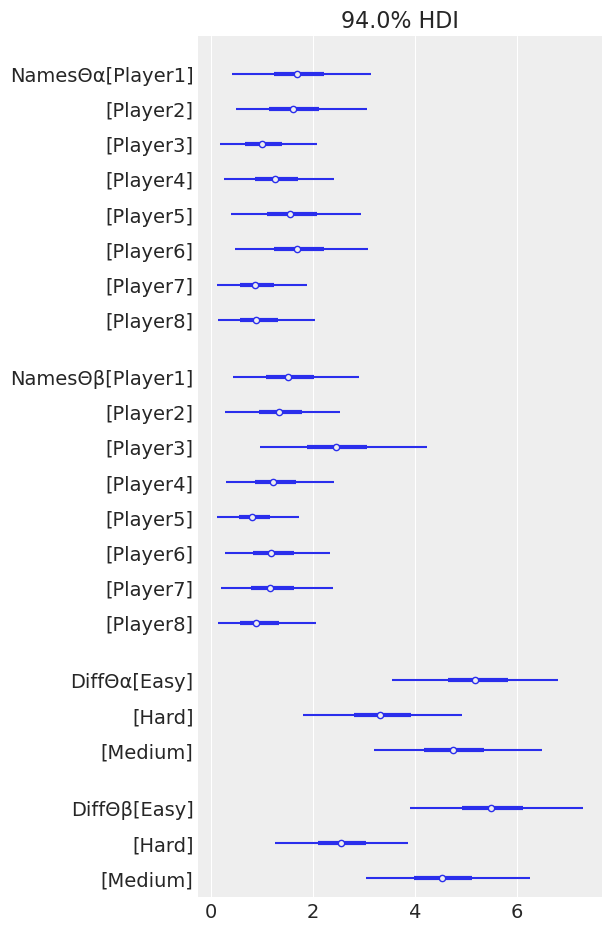

In [18]:
az.plot_forest(trace0, var_names=['NamesΘα', 'NamesΘβ', 'DiffΘα', 'DiffΘβ'], combined=True)

## Plot Coefficients of factor-interactions

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

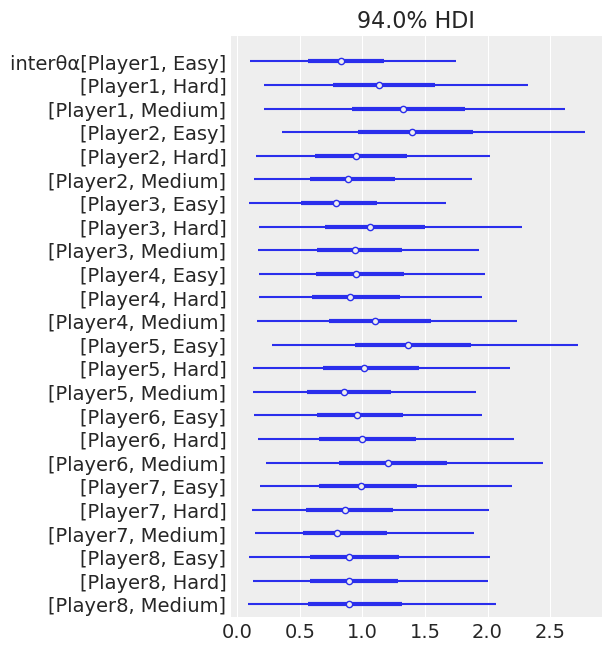

In [19]:
az.plot_forest(trace0, var_names=['interθα'], combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

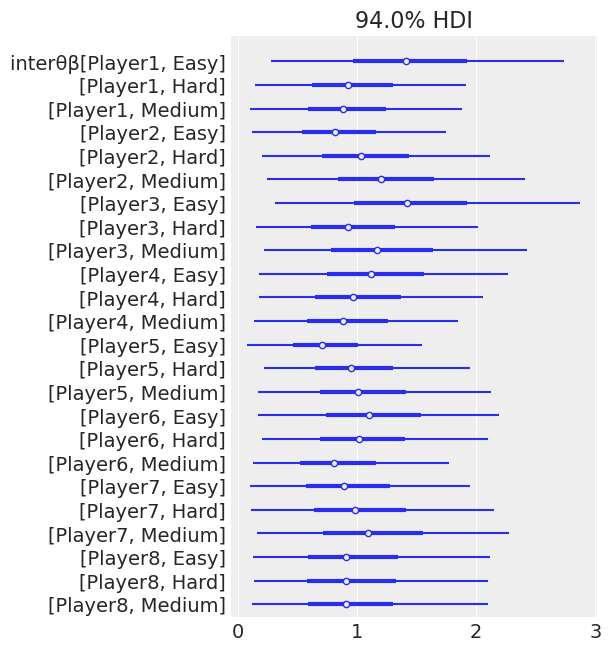

In [20]:
az.plot_forest(trace0, var_names=['interθβ'], combined=True)

In [21]:
az.summary(trace0, var_names=['NamesΘα', 'NamesΘβ', 'DiffΘα', 'DiffΘβ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
NamesΘα[Player1],1.767,0.744,0.421,3.146,0.013,0.009,2956.0,2187.0,1.0
NamesΘα[Player2],1.679,0.709,0.493,3.067,0.012,0.008,3412.0,2954.0,1.0
NamesΘα[Player3],1.077,0.540,0.189,2.083,0.008,0.006,3931.0,2354.0,1.0
NamesΘα[Player4],1.325,0.615,0.259,2.410,0.011,0.008,2786.0,2129.0,1.0
NamesΘα[Player5],1.625,0.707,0.408,2.937,0.012,0.009,3155.0,2210.0,1.0
NamesΘα[Player6],1.756,0.719,0.477,3.081,0.012,0.008,3351.0,2123.0,1.0
NamesΘα[Player7],0.959,0.511,0.122,1.894,0.007,0.005,4584.0,2400.0,1.0
NamesΘα[Player8],0.999,0.568,0.149,2.033,0.007,0.006,5405.0,2453.0,1.0
NamesΘβ[Player1],1.591,0.682,0.438,2.902,0.011,0.008,3727.0,2476.0,1.0
NamesΘβ[Player2],1.401,0.621,0.288,2.525,0.011,0.008,3041.0,2122.0,1.0


# Compare

In [13]:
# az.plot_forest([trace0, trace1], var_names=['Θα', 'Θβ'], combined=True)
# az.compare({'BB': trace0, 'BB2': trace1}, 'waic')